# Anomaly Detection with Generative Models

Are the simple generative models that we created in the last notebook actually useful for anything? Certainly not for sampling, but perhaps they encode enough information to at least tell us if an image could have originated from our training distribution.

To do this, we're going to consider the *likelihoods* given by our generative model. Since we originally trained our generative model to maximize the likelihood anyways, it makes sense that it should give a high value for the likelihood to images in our training dataset and other images similar to that. The hope is that it would give a low value of the likelihood to other images, not in our distribution. 

For this experiment, we're going to use 3 datasets of 28x28 black-and-white images:

* **MNIST**: Hand-written digits
* **Fashion-MNIST**: Images of clothing items
* **K-MNIST**: Hand-written Japanese characters in cursive Kuzushiji style

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scripts import kmnist_utils
import os
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Datasets

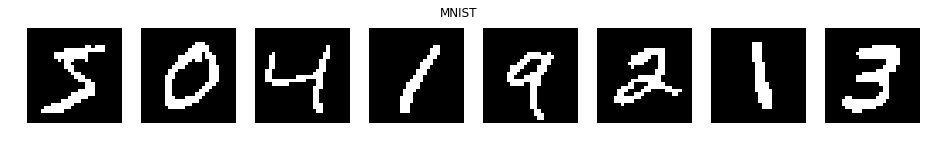

In [116]:
(x_train_mnist, _), (x_test_mnist, _) = tf.keras.datasets.mnist.load_data()
x_train_mnist = np.rint(x_train_mnist.astype(float)/255)  # Binarize the images.
x_test_mnist = np.rint(x_test_mnist.astype(float)/255)  # Binarize the images.

n_show = 8

# Show some examples.
_, ax = plt.subplots(1, 8, figsize=[16, 2])
plt.suptitle('MNIST')
for i in range(n_show):
    ax[i].imshow(x_train_mnist[i], cmap='gray')
    ax[i].set_axis_off()

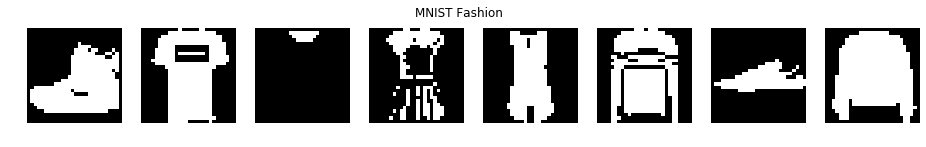

In [117]:
(x_train_fmnist, _), (x_test_fmnist, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train_fmnist = np.rint(x_train_fmnist.astype(float)/255)  # Binarize the images.
x_test_fmnist = np.rint(x_test_fmnist.astype(float)/255)  # Binarize the images.

n_show = 8

# Show some examples.
_, ax = plt.subplots(1, 8, figsize=[16, 2])
plt.suptitle('MNIST Fashion')
for i in range(n_show):
    ax[i].imshow(x_train_fmnist[i], cmap='gray')
    ax[i].set_axis_off()

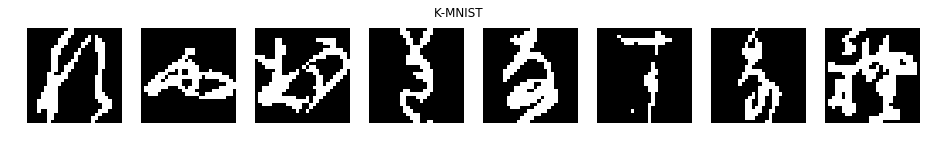

In [186]:
(x_train_kmnist, _), (x_test_kmnist, _) = kmnist_utils.load_data()
x_train_kmnist = np.rint(x_train_kmnist.astype(float)/255)  # Binarize the images.
x_test_kmnist = np.rint(x_test_kmnist.astype(float)/255)  # Binarize the images.

n_show = 8

# Show some examples.
_, ax = plt.subplots(1, 8, figsize=[16, 2])
plt.suptitle('K-MNIST')
for i in range(n_show):
    ax[i].imshow(x_train_kmnist[i], cmap='gray')
    ax[i].set_axis_off()

## Train a Simple Generative Model on MNIST

Let's train a generative model on MNIST and have it evaluate the likelihoods on the other ones

Text(0.5, 1.0, 'Bernoulli probabilities for MNIST')

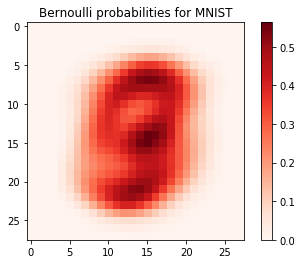

In [118]:
bernoulli_probabilities = np.sum(x_train_mnist, axis=0)/x_train_mnist.shape[0]
plt.imshow(bernoulli_probabilities, cmap='Reds')
plt.colorbar()
plt.title('Bernoulli probabilities for MNIST')

In [190]:
likelihood_mnist = np.abs((1 - x_test_mnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_mnist = np.clip(likelihood_mnist, 1e-7, None)
log_likelihood_mnist = np.log(likelihood_mnist).sum(axis=1)

likelihood_fmnist = np.abs((1 - x_test_fmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_fmnist = np.clip(likelihood_fmnist, 1e-7, None)
log_likelihood_fmnist = np.log(likelihood_fmnist).sum(axis=1)

likelihood_kmnist = np.abs((1 - x_test_kmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_kmnist = np.clip(likelihood_kmnist, 1e-7, None)
log_likelihood_kmnist = np.log(likelihood_kmnist).sum(axis=1)

bins = np.histogram(np.hstack((log_likelihood_mnist, log_likelihood_fmnist, log_likelihood_kmnist)), bins=40)[1]

Text(0.5, 1.0, 'K-MNIST: 58.01% detected')

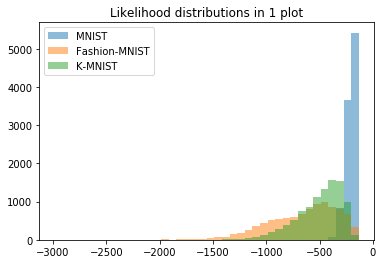

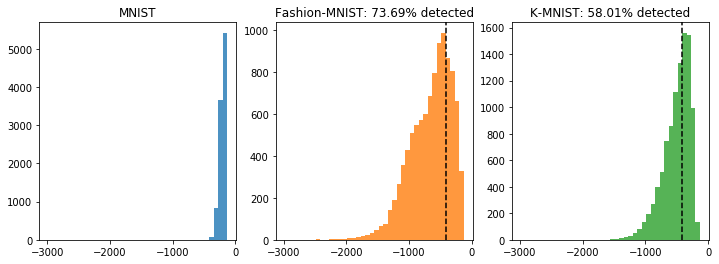

In [215]:
plt.hist(log_likelihood_mnist, bins, alpha=0.5, label='MNIST');
plt.hist(log_likelihood_fmnist, bins, alpha=0.5, label='Fashion-MNIST');
plt.hist(log_likelihood_kmnist, bins, alpha=0.5, label='K-MNIST');
plt.legend()
plt.title('Likelihood distributions in 1 plot')

min_log_likelihood_mnist = log_likelihood_mnist.min()
perc_fmnist_detected = round(100*np.mean(log_likelihood_fmnist<min_log_likelihood_mnist),2)
perc_kmnist_detected = round(100*np.mean(log_likelihood_kmnist<min_log_likelihood_mnist),2)

fig, ax = plt.subplots(figsize=[12, 4], nrows=1, ncols=3, sharex=True)
ax[0].hist(log_likelihood_mnist, bins, color='C0', alpha=0.8); ax[0].set_title('MNIST')
ax[1].hist(log_likelihood_fmnist, bins, color='C1', alpha=0.8)
ax[1].axvline(min_log_likelihood_mnist, c='k', ls='--')
ax[1].set_title('Fashion-MNIST: {}% detected'.format(perc_fmnist_detected))
ax[2].hist(log_likelihood_kmnist, bins, color='C2', alpha=0.8); ax[2].set_title('K-MNIST')
ax[2].axvline(min_log_likelihood_mnist, c='k', ls='--')
ax[2].set_title('K-MNIST: {}% detected'.format(perc_kmnist_detected))

Seems pretty good, yeah? Let's just confirm our results by running the experiment the other way around.

## Train on Fashion-MNIST

Text(0.5, 1.0, 'Bernoulli probabilities for Fasion-MNIST')

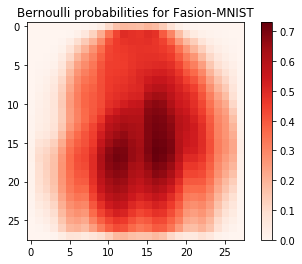

In [233]:
bernoulli_probabilities = np.sum(x_train_fmnist, axis=0)/x_train_fmnist.shape[0]
plt.imshow(bernoulli_probabilities, cmap='Reds')
plt.colorbar()
plt.title('Bernoulli probabilities for Fasion-MNIST')

In [234]:
likelihood_mnist = np.abs((1 - x_test_mnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_mnist = np.clip(likelihood_mnist, 1e-7, None)
log_likelihood_mnist = np.log(likelihood_mnist).sum(axis=1)

likelihood_fmnist = np.abs((1 - x_test_fmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_fmnist = np.clip(likelihood_fmnist, 1e-7, None)
log_likelihood_fmnist = np.log(likelihood_fmnist).sum(axis=1)

likelihood_kmnist = np.abs((1 - x_test_kmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_kmnist = np.clip(likelihood_kmnist, 1e-7, None)
log_likelihood_kmnist = np.log(likelihood_kmnist).sum(axis=1)

bins = np.histogram(np.hstack((log_likelihood_mnist, log_likelihood_fmnist, log_likelihood_kmnist)), bins=40)[1]

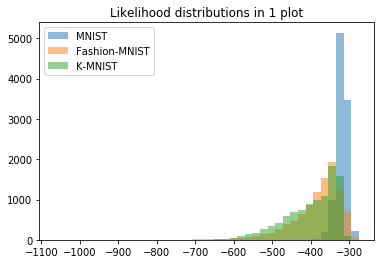

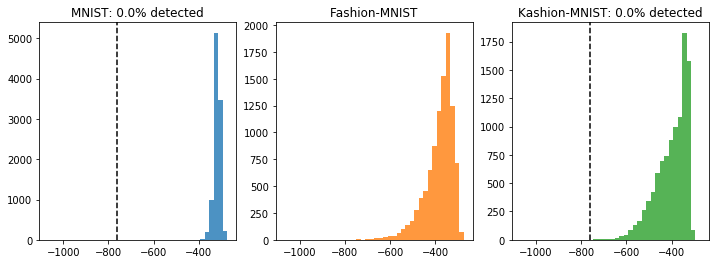

In [235]:
plt.hist(log_likelihood_mnist, bins, alpha=0.5, label='MNIST');
plt.hist(log_likelihood_fmnist, bins, alpha=0.5, label='Fashion-MNIST');
plt.hist(log_likelihood_kmnist, bins, alpha=0.5, label='K-MNIST');
plt.legend()
plt.title('Likelihood distributions in 1 plot')

min_log_likelihood_fmnist = log_likelihood_fmnist.min()
perc_mnist_detected = round(100*np.mean(log_likelihood_mnist<min_log_likelihood_fmnist),2)
perc_kmnist_detected = round(100*np.mean(log_likelihood_kmnist<min_log_likelihood_fmnist),2)

fig, ax = plt.subplots(figsize=[12, 4], nrows=1, ncols=3, sharex=True)
ax[0].hist(log_likelihood_mnist, bins, color='C0', alpha=0.8); 
ax[0].set_title('MNIST: {}% detected'.format(perc_mnist_detected))
ax[0].axvline(min_log_likelihood_kmnist, c='k', ls='--')

ax[1].hist(log_likelihood_fmnist, bins, color='C1', alpha=0.8)
ax[1].set_title('Fashion-MNIST')

ax[2].hist(log_likelihood_kmnist, bins, color='C2', alpha=0.8); ax[2].set_title('K-MNIST')
ax[2].set_title('Kashion-MNIST: {}% detected'.format(perc_kmnist_detected))
ax[2].axvline(min_log_likelihood_kmnist, c='k', ls='--')

## Train on K-MNIST

Text(0.5, 1.0, 'Bernoulli probabilities for Fasion-MNIST')

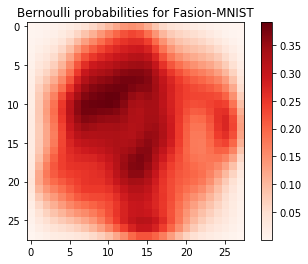

In [222]:
bernoulli_probabilities = np.sum(x_train_kmnist, axis=0)/x_train_kmnist.shape[0]
plt.imshow(bernoulli_probabilities, cmap='Reds')
plt.colorbar()
plt.title('Bernoulli probabilities for Fasion-MNIST')

In [225]:
likelihood_mnist = np.abs((1 - x_test_mnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_mnist = np.clip(likelihood_mnist, 1e-7, None)
log_likelihood_mnist = np.log(likelihood_mnist).sum(axis=1)

likelihood_fmnist = np.abs((1 - x_test_fmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_fmnist = np.clip(likelihood_fmnist, 1e-7, None)
log_likelihood_fmnist = np.log(likelihood_fmnist).sum(axis=1)

likelihood_kmnist = np.abs((1 - x_test_kmnist) - bernoulli_probabilities).reshape(-1, 784)
likelihood_kmnist = np.clip(likelihood_kmnist, 1e-7, None)
log_likelihood_kmnist = np.log(likelihood_kmnist).sum(axis=1)

bins = np.histogram(np.hstack((log_likelihood_mnist, log_likelihood_fmnist, log_likelihood_kmnist)), bins=40)[1]

Text(0.5, 1.0, 'K-MNIST')

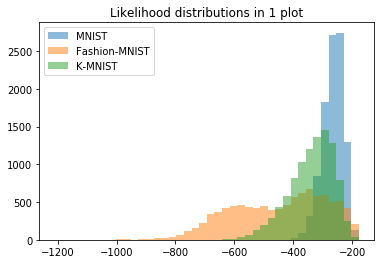

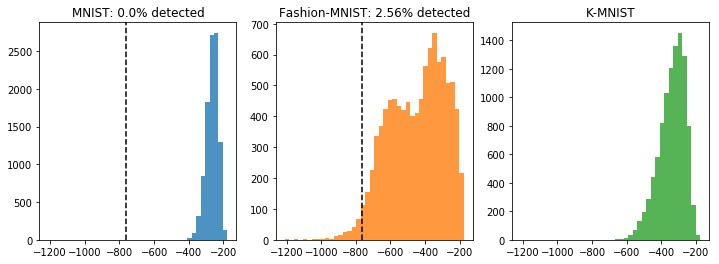

In [232]:
plt.hist(log_likelihood_mnist, bins, alpha=0.5, label='MNIST');
plt.hist(log_likelihood_fmnist, bins, alpha=0.5, label='Fashion-MNIST');
plt.hist(log_likelihood_kmnist, bins, alpha=0.5, label='K-MNIST');
plt.legend()
plt.title('Likelihood distributions in 1 plot')

min_log_likelihood_kmnist = log_likelihood_kmnist.min()
perc_mnist_detected = round(100*np.mean(log_likelihood_mnist<min_log_likelihood_kmnist),2)
perc_fmnist_detected = round(100*np.mean(log_likelihood_fmnist<min_log_likelihood_kmnist),2)

fig, ax = plt.subplots(figsize=[12, 4], nrows=1, ncols=3, sharex=True)
ax[0].hist(log_likelihood_mnist, bins, color='C0', alpha=0.8); 
ax[0].set_title('MNIST: {}% detected'.format(perc_mnist_detected))
ax[0].axvline(min_log_likelihood_kmnist, c='k', ls='--')

ax[1].hist(log_likelihood_fmnist, bins, color='C1', alpha=0.8)
ax[1].axvline(min_log_likelihood_kmnist, c='k', ls='--')
ax[1].set_title('Fashion-MNIST: {}% detected'.format(perc_fmnist_detected))

ax[2].hist(log_likelihood_kmnist, bins, color='C2', alpha=0.8); ax[2].set_title('K-MNIST')
ax[2].set_title('K-MNIST')

What does this show? A bad generative model, one that does not truly capture the dependencies in the inputs samples, can be a really bad anomaly detector! Why does this happen? Basically because the sparser the image (the fewer the "white" pixels), the higher the likelihood that is reported on all of the images. This is because the likelihood of any given pixel being white is usually  going to be low (check out the heat maps above). This means that images with most pixels being "black" will result in a higher likelihood being assigned. This is why the likelihood should be taken with a grain of salt when being used to detect anomalies.